### 🧠 What is Self-Reflection in RAG?
Self-reflection = LLM evaluates its own output:
“Is this clear, complete, and accurate?”

Self-Reflection in RAG using LangGraph, we’ll design a workflow where the agent:

1. Generates an initial answer using retrieved context
2. Reflects on that answer with a dedicated self-critic LLM step
3. If unsatisfied, it can revise the query, retrieve again, or regenerate the answer

In [1]:
import os
from typing import List
from pydantic import BaseModel
from langchain_openai import OpenAIEmbeddings
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import TextLoader
from langgraph.graph import StateGraph, END

In [2]:
# load llm models
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv
load_dotenv()
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
llm=init_chat_model("openai:gpt-4o")

In [3]:
docs = TextLoader(r"..\assets\research_notes.txt").load()
chunks = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50).split_documents(docs)
vectorstore = FAISS.from_documents(chunks, OpenAIEmbeddings())
retriever = vectorstore.as_retriever()

In [4]:
# -------------------------
# 2. State Definition
# -------------------------
class RAGReflectionState(BaseModel):
    question: str
    retrieved_docs: List[Document] = []
    answer: str = ""
    reflection: str = ""
    revised: bool = False
    attempts: int = 0

In [5]:
# -------------------------
# 3. Nodes
# -------------------------

# a. Retrieve
def retrieve_docs(state: RAGReflectionState) -> RAGReflectionState:
    docs = retriever.invoke(state.question)
    return state.model_copy(update={"retrieved_docs": docs})

# b. Generate Answer
def generate_answer(state: RAGReflectionState) -> RAGReflectionState:
    
    context = "\n\n".join([doc.page_content for doc in state.retrieved_docs])
    prompt = f"""   Use the following context to answer the question:

                    Context:
                    {context}

                    Question:
                    {state.question}
                    """
    answer = llm.invoke(prompt).content.strip()
    return state.model_copy(update={"answer": answer, "attempts": state.attempts + 1})

In [6]:
# c. Self-Reflect
def reflect_on_answer(state: RAGReflectionState) -> RAGReflectionState:
    
    prompt = f"""Reflect on the following answer to see if it fully addresses the question. 
                 State YES if it is complete and correct, or NO with an explanation.

                 Question: {state.question}

                 Answer: {state.answer}

                 Respond like:
                 Reflection: YES or NO
                 Explanation: ...
               """
    result = llm.invoke(prompt).content
    is_ok = "reflection: yes" in result.lower()
    return state.model_copy(update={"reflection": result, "revised": not is_ok})

In [7]:
# d. Finalizer
def finalize(state: RAGReflectionState) -> RAGReflectionState:
    return state

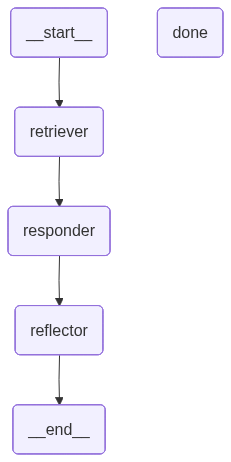

In [8]:
# -------------------------
# 4. LangGraph DAG
# -------------------------
builder = StateGraph(RAGReflectionState)

builder.add_node("retriever", retrieve_docs)
builder.add_node("responder", generate_answer)
builder.add_node("reflector", reflect_on_answer)
builder.add_node("done", finalize)

builder.set_entry_point("retriever")

builder.add_edge("retriever", "responder")
builder.add_edge("responder", "reflector")
builder.add_conditional_edges(
    "reflector",
    lambda s: "done" if not s.revised or s.attempts >= 2 else "retriever"
)

builder.add_edge("done", END)
graph = builder.compile()
graph

In [18]:
print(dir(graph))


['InputType', 'OutputType', '__abstractmethods__', '__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__or__', '__orig_bases__', '__orig_class__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__ror__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abatch_with_config', '_abc_impl', '_acall_with_config', '_aprepare_state_snapshot', '_atransform_stream_with_config', '_batch_with_config', '_call_with_config', '_defaults', '_migrate_checkpoint', '_prepare_state_snapshot', '_repr_mimebundle_', '_transform_stream_with_config', 'abatch', 'abatch_as_completed', 'abulk_update_state', 'aclear_cache', 'aget_graph', 'aget_state', 'aget_state_history', 'aget_subgraphs', 'ainvoke', 'as_tool', 'assign', 'astream',

In [19]:
g = graph.get_graph()
print(g)


Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=RunnableCallable(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), 'retriever': Node(id='retriever', name='retriever', data=retriever(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), 'responder': Node(id='responder', name='responder', data=responder(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), 'reflector': Node(id='reflector', name='reflector', data=reflector(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), 'done': Node(id='done', name='done', data=done(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), '__end__': Node(id='__end__', name='__end__', data=None, metadata=None)}, edges=[Edge(source='__start__', target='retriever', data=None, conditional=False), Edge(source='responder', target='reflector', data=None, conditional=False), Edge(source='retriever', target='resp

In [ ]:
# -------------------------
# 5. Run the Agent
# -------------------------
if __name__ == "__main__":
    user_query = "What is LoRA tuning?"
    init_state = RAGReflectionState(question=user_query)
    result = graph.invoke(init_state)

    print("\n🧠 Final Answer:\n", result["answer"])
    print("\n🔁 Reflection Log:\n", result["reflection"])
    print("🔄 Total Attempts:", result["attempts"])


🧠 Final Answer:
 LoRA tuning is a technique used for adapter-based fine-tuning that involves a low-rank adaptation approach to efficiently train machine learning models. In the context provided, LoRA tuning is characterized by:

- Use of a rank of 8 and a dropout rate of 0.05.
- Reduction of the GPU memory footprint by 60%.
- Compatibility with the PEFT (Parameter Efficient Fine-Tuning) library.

LoRA tuning allows for the adaptation of models with a reduced computational and memory burden, making it especially useful for large-scale models where full retraining would be resource-intensive.

🔁 Reflection Log:
 Reflection: NO  
Explanation: While the answer provides some useful information about LoRA tuning, it is not fully complete. The explanation touches on the efficiency and specifics of LoRA usage, such as reducing the GPU memory footprint and its compatibility with the PEFT library. However, it misses detailing how LoRA works in practice – such as how it decomposes weight matrice